In [222]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

In [223]:
gm_data = [os.path.basename(file) for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
k5_data = [os.path.basename(file) for file in (glob.glob("data/trained_models/2025-07-25-10/*.csv") + glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

In [224]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [225]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [226]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [227]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        plt.clf()

        return signal_index, only_0s_index

In [228]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()

for file in data:
    df = pd.read_csv(f"data/trained_models/2025-07-23-11/{file}")
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [229]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.487524
2     0.450801
3     0.467099
4     0.410750
5     0.520842
6     0.488936
7     0.474234
8     0.479356
9     0.442097
10    0.471362
11    0.443849
12    0.472490
Name: Error, dtype: float64

Max Error Fold: 0.5208424177051227 at Fold 5

Min Error Fold: 0.41074973751623667 at Fold 4

Mean Error: 0.4689510406359734

Max Error: 4.7232875199999995

Min Error: 1.399999999995849e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.490137
2     0.497488
3     0.460478
4     0.431709
5     0.496517
6     0.494608
7     0.491097
8     0.499403
9     0.479435
10    0.510080
11    0.491731
12    0.509476
Name: Error, dtype: float64

Max Error Fold: 0.5100804644149064 at Fold 10

Min Error Fold: 0.4317085177459157 at Fold 4

Mean Error: 0.49039611933015653

Max Error: 4.80842363

Min Error: 3.740000000007626e-05 



Negative Predictions

GM12878: 
Threshold: 0
Genes per Fold: 
4: 16
Total Number of Matches: 16
Total Matches with >= 1 Non-Zero Value: 1
Percentage of TSSs with No Signal: 93.75%
Genes w/ Signal: ['ENSG00000225630']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2']


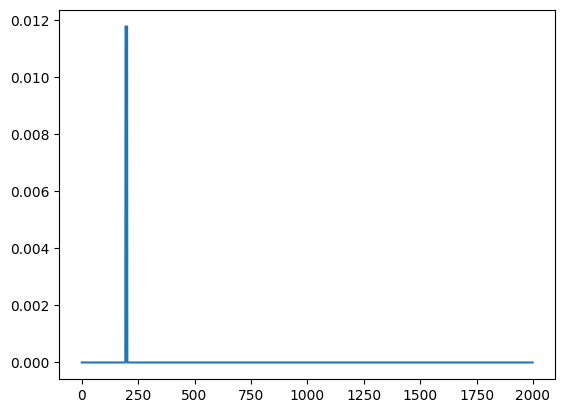

K562: 
Threshold: 0
Genes per Fold: 
3: 105
4: 10
8: 1
10: 1
Total Number of Matches: 117
Total Matches with >= 1 Non-Zero Value: 44
Percentage of TSSs with No Signal: 62.39%
Genes w/ Signal: ['ENSG00000225630', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197530', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000162585', 'ENSG00000157933', 'ENSG00000157933_1', 'ENSG00000157870', 'ENSG00000116213', 'ENSG00000078900', 'ENSG00000078900_1', 'ENSG00000293478', 'ENSG00000162592', 'ENSG00000235169

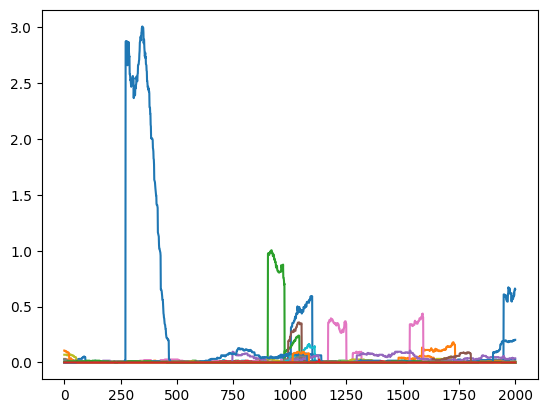

<Figure size 640x480 with 0 Axes>

In [230]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/neg_preds", "K562")

Low Errors

In [231]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.007918
0.05    0.040805
0.10    0.073478
Name: Error, dtype: float64

In [232]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.007989
0.05    0.034364
0.10    0.061697
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 2
2: 9
3: 3
4: 6
5: 2
6: 4
7: 1
8: 3
9: 2
10: 3
11: 5
12: 3
Total Number of Matches: 43
Total Matches with >= 1 Non-Zero Value: 23
Percentage of TSSs with No Signal: 46.51%
Genes w/ Signal: ['ENSG00000225630', 'ENSG00000229344', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000169962', 'ENSG00000162576']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000184163', 'ENSG000001

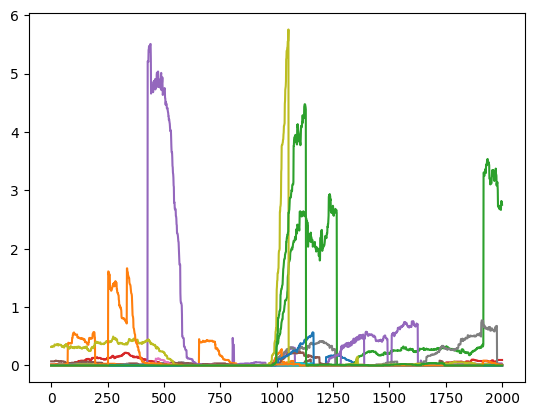

K562: 
Threshold: 0.001
Genes per Fold: 
1: 1
2: 3
3: 2
4: 3
5: 3
6: 3
7: 4
8: 2
10: 3
11: 1
12: 2
Total Number of Matches: 27
Total Matches with >= 1 Non-Zero Value: 10
Percentage of TSSs with No Signal: 62.96%
Genes w/ Signal: ['ENSG00000229344', 'ENSG00000198744', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000237330']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591']


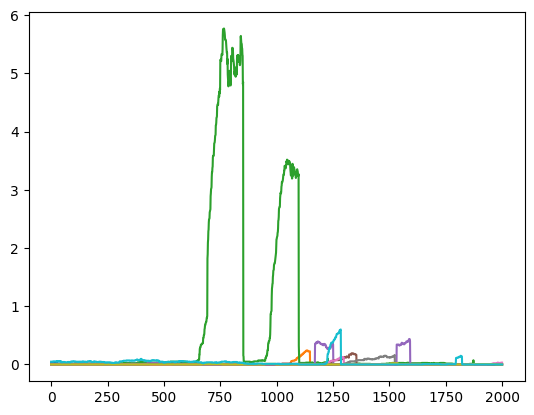

<Figure size 640x480 with 0 Axes>

In [233]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "K562")

High Errors

In [234]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.029975
0.95    1.418183
0.99    2.301041
Name: Error, dtype: float64

In [235]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.149304
0.95    1.612229
0.99    2.410188
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 317
2: 267
3: 202
4: 137
5: 276
6: 248
7: 198
8: 297
9: 269
10: 307
11: 215
12: 279
Total Number of Matches: 3012
Total Matches with >= 1 Non-Zero Value: 2573
Percentage of TSSs with No Signal: 14.58%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENS

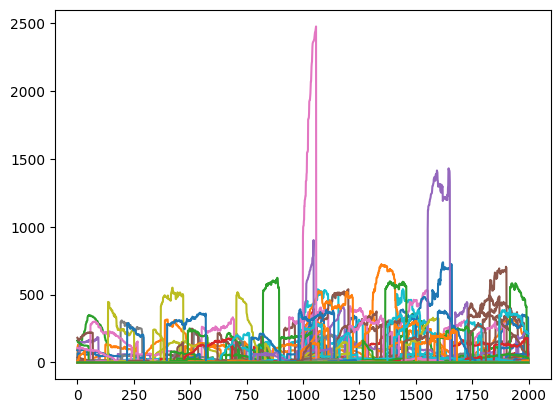

K562: 
Threshold: 1
Genes per Fold: 
1: 357
2: 330
3: 247
4: 175
5: 275
6: 251
7: 247
8: 345
9: 322
10: 426
11: 281
12: 357
Total Number of Matches: 3613
Total Matches with >= 1 Non-Zero Value: 3048
Percentage of TSSs with No Signal: 15.64%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000107404', 'ENSG0000

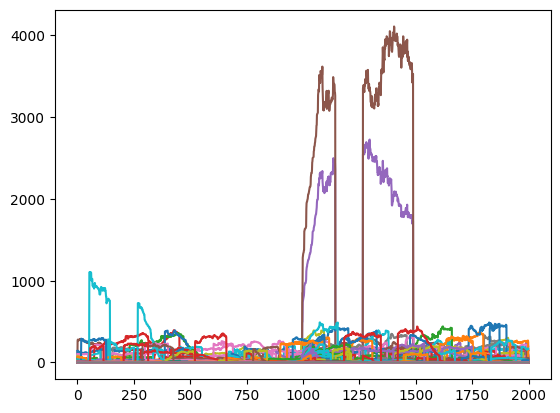

<Figure size 640x480 with 0 Axes>

In [236]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "K562")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1086
2: 1120
3: 858
4: 822
5: 659
6: 886
7: 1155
8: 1420
9: 1143
10: 1319
11: 1152
12: 1269
Total Number of Matches: 12889
Total Matches with >= 1 Non-Zero Value: 8934
Percentage of TSSs with No Signal: 30.69%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG000000081

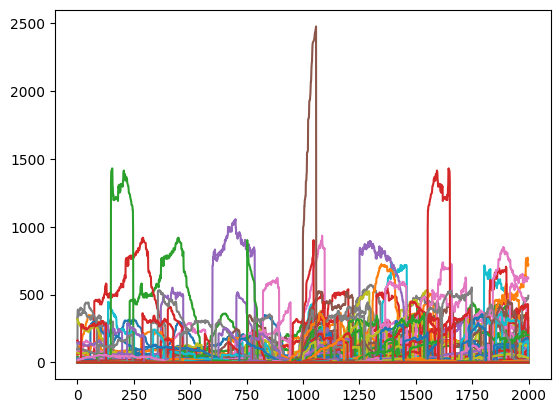

K562
Threshold: 0
Genes per Fold: 
1: 974
2: 789
3: 980
4: 378
5: 773
6: 694
7: 865
8: 991
9: 1007
10: 1214
11: 712
12: 1104
Total Number of Matches: 10481
Total Matches with >= 1 Non-Zero Value: 7581
Percentage of TSSs with No Signal: 27.67%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG0000

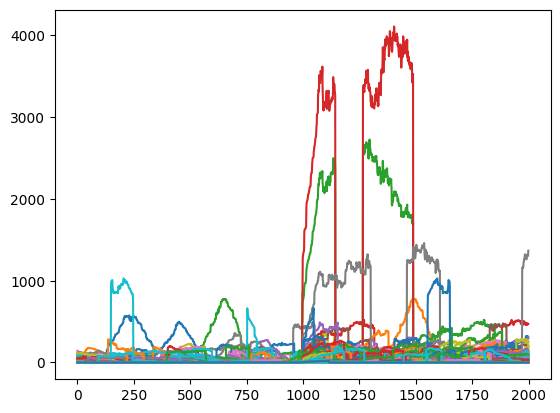

<Figure size 640x480 with 0 Axes>

In [237]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/overestimates", "K562")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1700
2: 1473
3: 1079
4: 767
5: 1664
6: 1103
7: 934
8: 1182
9: 1355
10: 1673
11: 1107
12: 1431
Total Number of Matches: 15468
Total Matches with >= 1 Non-Zero Value: 8938
Percentage of TSSs with No Signal: 42.22%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885',

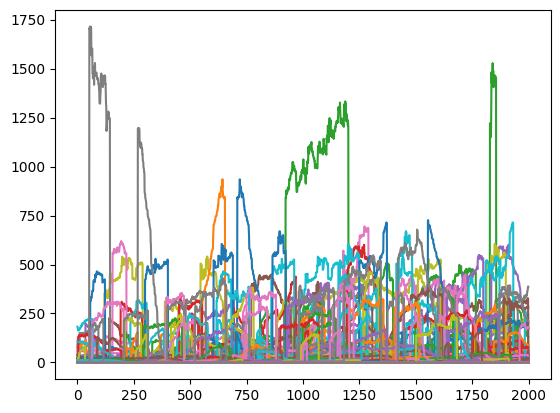

K562
Threshold: 0
Genes per Fold: 
1: 1812
2: 1804
3: 957
4: 1211
5: 1550
6: 1295
7: 1224
8: 1611
9: 1491
10: 1778
11: 1547
12: 1596
Total Number of Matches: 17876
Total Matches with >= 1 Non-Zero Value: 10510
Percentage of TSSs with No Signal: 41.21%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000228594', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000078369_1', 'ENSG00000178821', 'ENSG00000142609', 

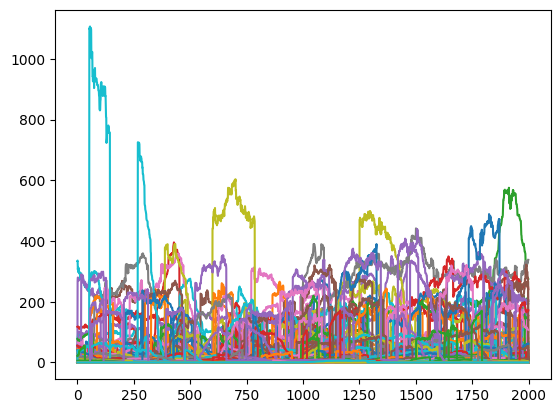

<Figure size 640x480 with 0 Axes>

In [238]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/underestimates", "K562")

Worst Errors (Over Expressed)

In [239]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(5, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(5, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
10600,ENSG00000100804,3.837597,0.0,5,NaN,3.837597,3.837597
816,ENSG00000176261,3.259053,0.0,1,NaN,3.259053,3.259053
2405,ENSG00000126067,3.257822,0.0,1,NaN,3.257822,3.257822
2427,ENSG00000160049,3.074574,0.0,1,NaN,3.074574,3.074574
1570,ENSG00000132485,3.050116,0.0,1,NaN,3.050116,3.050116


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
1198,ENSG00000162851,3.562582,0.0,1,541.599,3.562582,3.562582
875,ENSG00000117748,3.377295,0.0,1,881.266,3.377295,3.377295
39,ENSG00000143106,3.359196,0.0,1,2220.680,3.359196,3.359196
16274,ENSG00000213593,3.320452,0.0,8,NaN,3.320452,3.320452
1125,ENSG00000117697,3.195888,0.0,1,461.646,3.195888,3.195888


GM12878: 


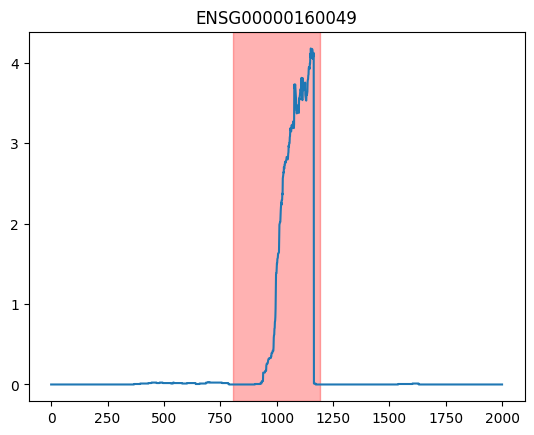

Pred: 3.074574
Actual: 0.0


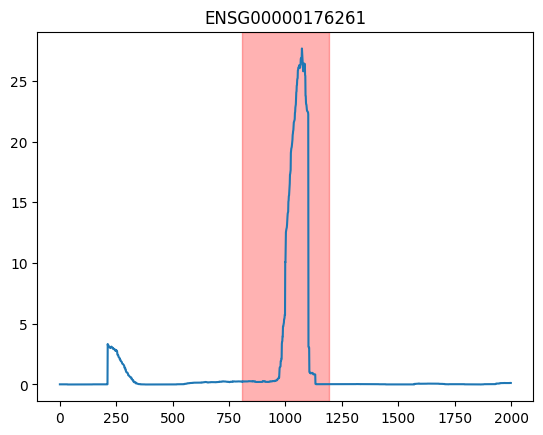

Pred: 3.2590528
Actual: 0.0


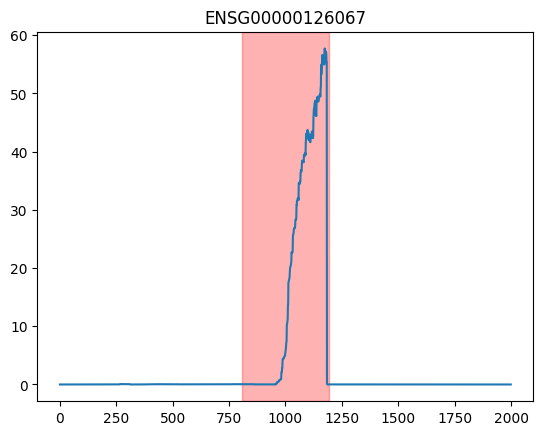

Pred: 3.2578223
Actual: 0.0


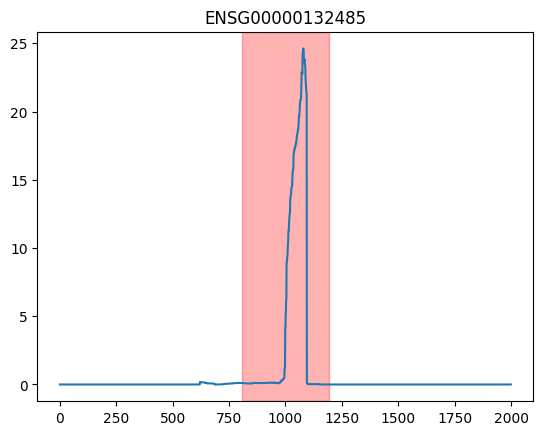

Pred: 3.0501163
Actual: 0.0


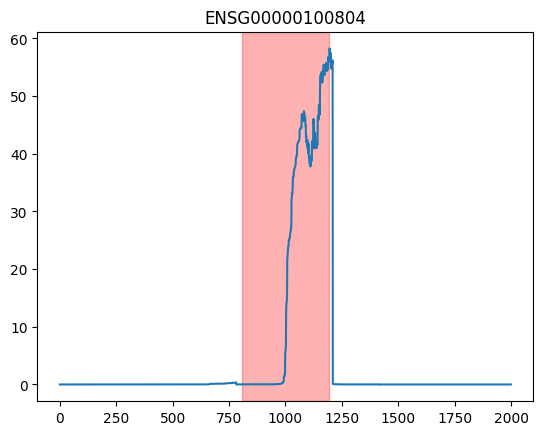

Pred: 3.837597
Actual: 0.0

K562: 


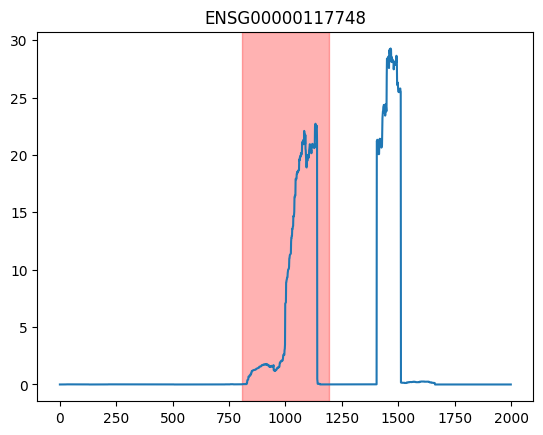

Pred: 3.377295
Actual: 0.0


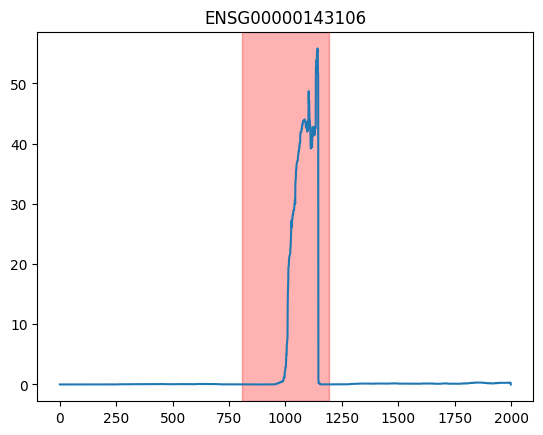

Pred: 3.359196
Actual: 0.0


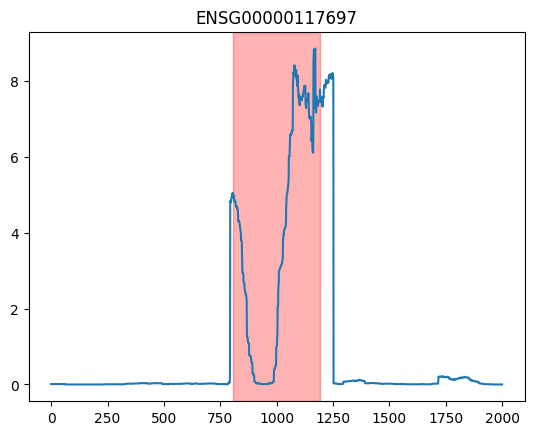

Pred: 3.1958876
Actual: 0.0


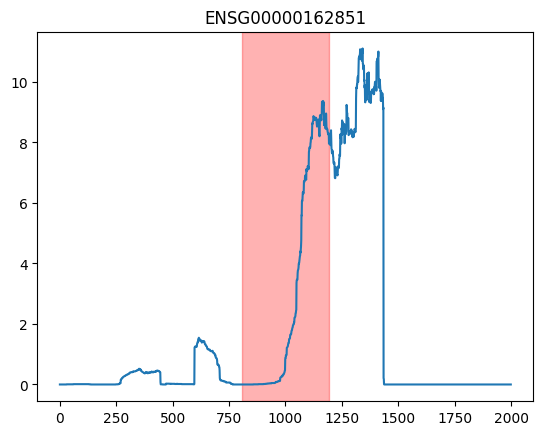

Pred: 3.5625825
Actual: 0.0


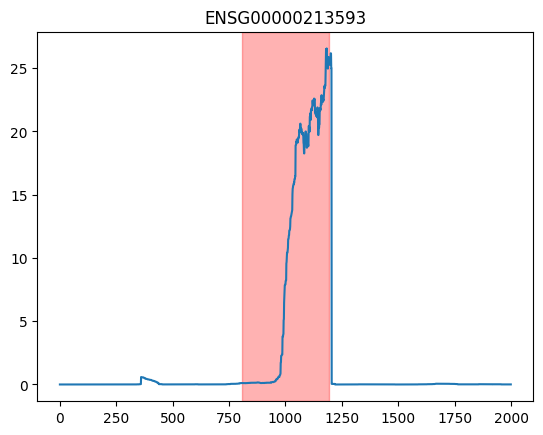

Pred: 3.3204522
Actual: 0.0


In [240]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

Worst Errors (Under Expressed)

In [241]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(5, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(5, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
18043,ENSG00000202538,1.110486,5.662860,9,460107.00,4.552374,-4.552374
25467,ENSG00000272160,0.165033,4.697162,11,49791.30,4.532129,-4.532129
19629,ENSG00000200795,0.957539,5.415317,9,260205.00,4.457778,-4.457778
16694,ENSG00000199325,0.200666,3.754244,8,5677.64,3.553579,-3.553579
646,ENSG00000199377,0.962247,4.507385,1,32164.10,3.545138,-3.545138


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
21283,ENSG00000142541,0.945669,4.377945,10,NaN,3.432277,-3.432277
25037,ENSG00000122862,0.448682,3.565910,11,48321.60,3.117228,-3.117228
11792,ENSG00000233440,0.222033,3.252559,6,466.40,3.030527,-3.030527
26371,ENSG00000253506,0.261255,3.284126,12,4388.55,3.022871,-3.022871
20342,ENSG00000180574,0.102649,3.124833,9,1220.50,3.022184,-3.022184


GM12878: 


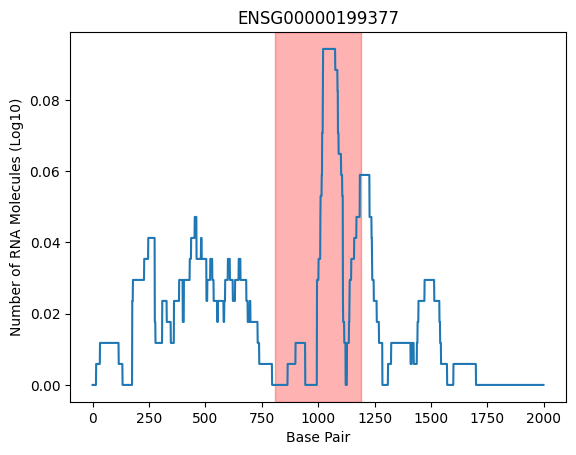

Pred: 0.96224725
Actual: 4.507385


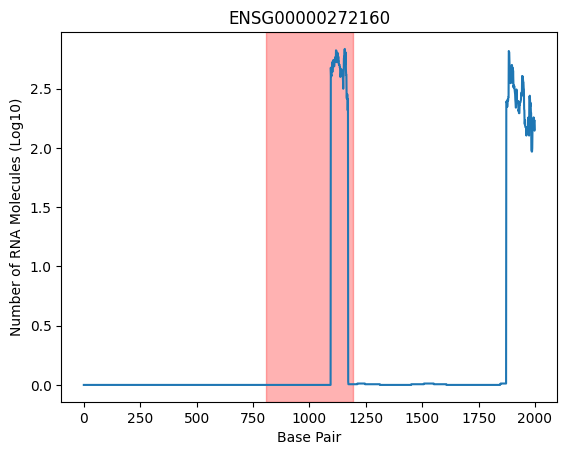

Pred: 0.16503319
Actual: 4.697162


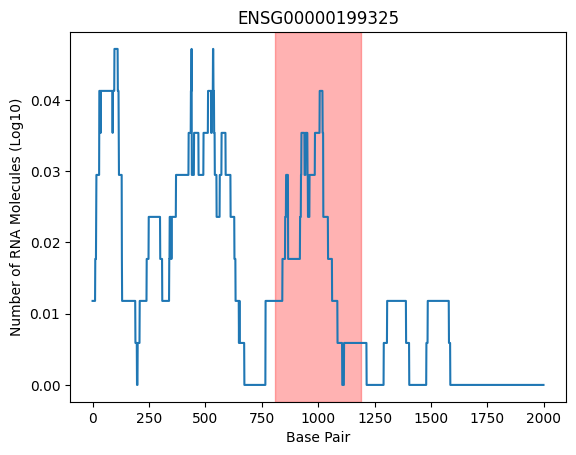

Pred: 0.2006657
Actual: 3.7542443


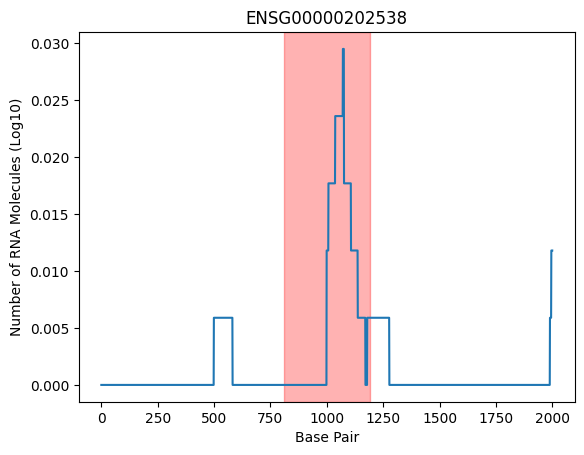

Pred: 1.1104861
Actual: 5.66286


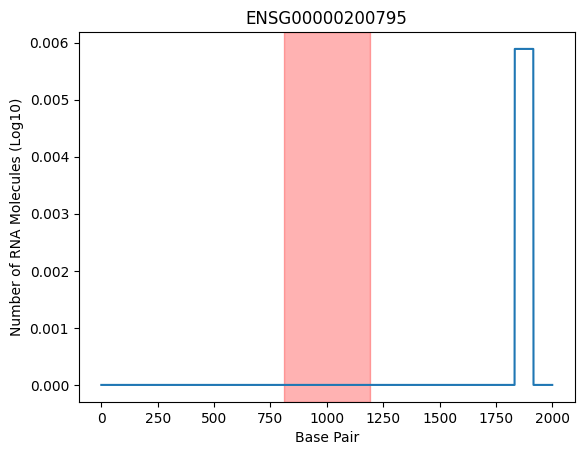

Pred: 0.9575392
Actual: 5.4153175

K562: 


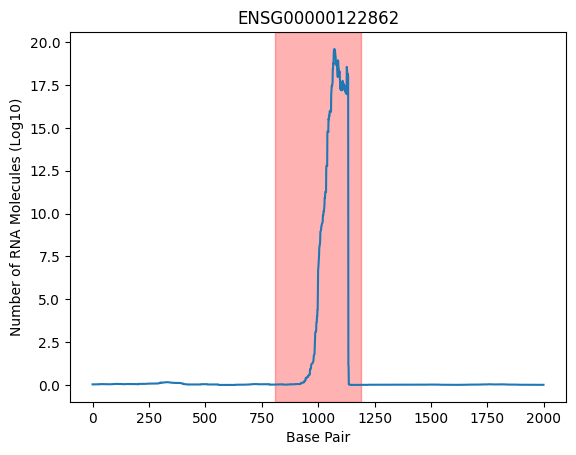

Pred: 0.44868228
Actual: 3.5659103


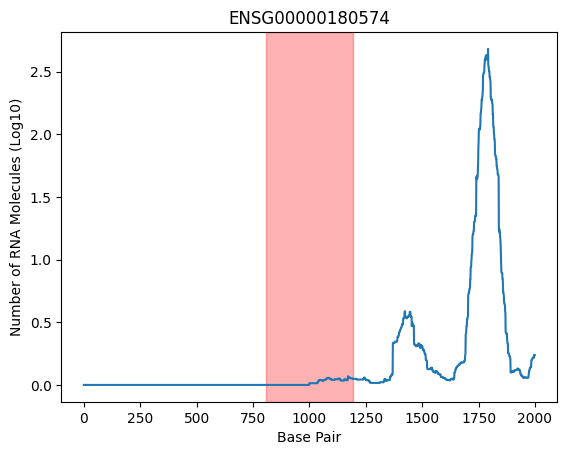

Pred: 0.10264936
Actual: 3.1248333


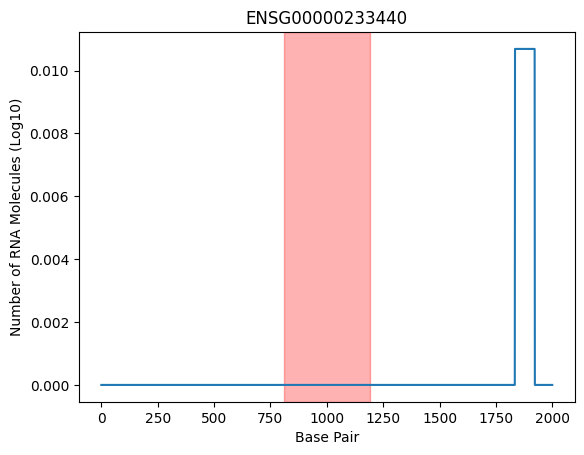

Pred: 0.22203277
Actual: 3.2525594


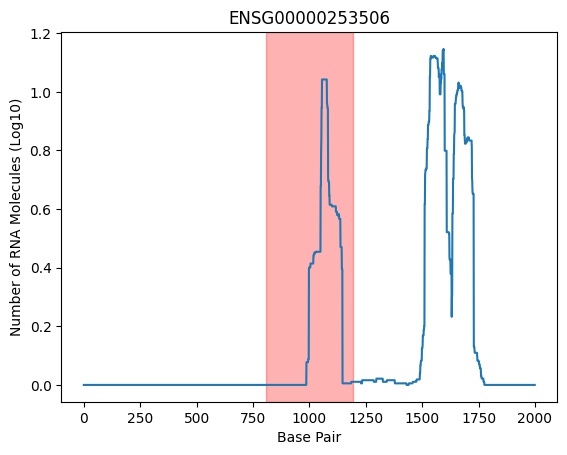

Pred: 0.26125535
Actual: 3.284126


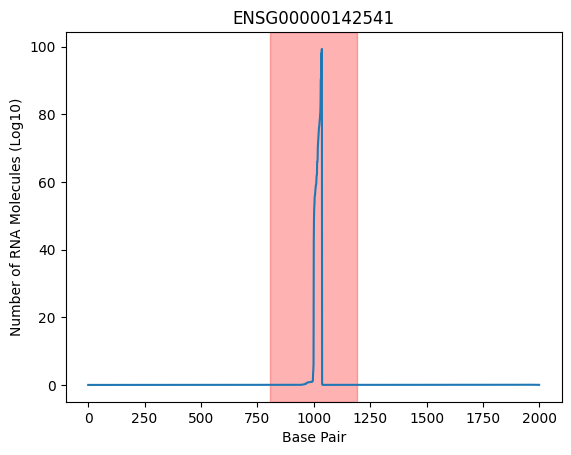

Pred: 0.9456686
Actual: 4.3779454


In [242]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

Best Errors (Over Expressed)

In [243]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(5, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(5, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
25048,ENSG00000040199,1.994963,1.994977,11,97.85000,0.000014,-0.000014
10316,ENSG00000100448,0.388099,0.388067,5,1.44381,0.000032,0.000032
24394,ENSG00000103264,2.487153,2.487326,11,306.13300,0.000174,-0.000174
25480,ENSG00000102974,2.835364,2.835043,11,682.98000,0.000320,0.000320
18212,ENSG00000094914_1,2.933462,2.933811,9,857.64000,0.000349,-0.000349


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
12365,ENSG00000243319_1,1.211982,1.211868,6,21.033,0.000114,0.000114
16644,ENSG00000183020,1.955528,1.955851,8,162.717,0.000323,-0.000323
24854,ENSG00000065809_1,0.653609,0.653155,11,NaN,0.000455,0.000455
935,ENSG00000158769,2.902838,2.904061,1,387.308,0.001223,-0.001223
24261,ENSG00000140694,2.723861,2.722443,11,793.241,0.001418,0.001418


GM12878: 


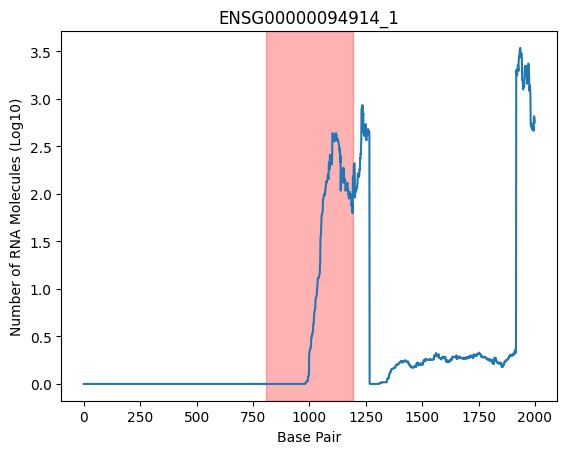

Pred: 2.933462
Actual: 2.9338112


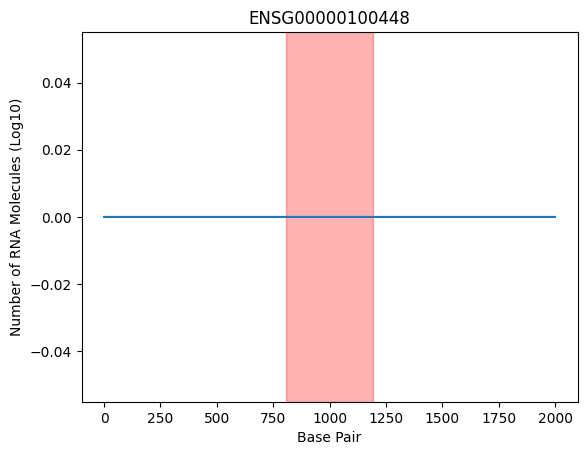

Pred: 0.3880993
Actual: 0.38806742


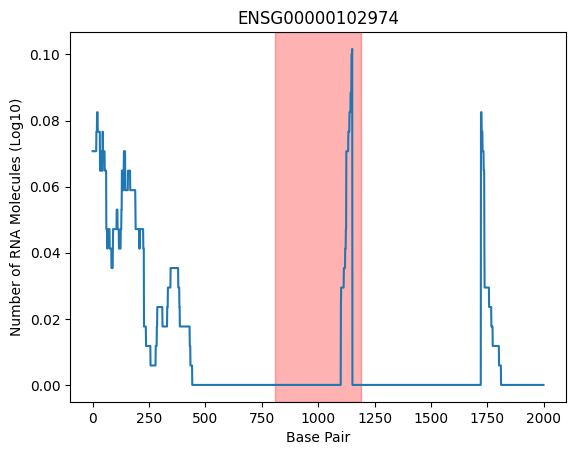

Pred: 2.8353636
Actual: 2.8350434


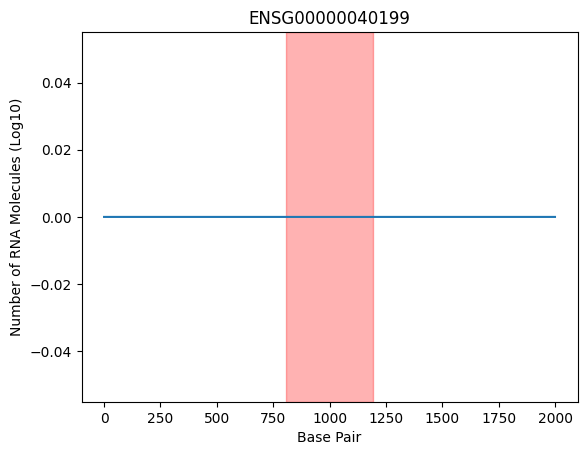

Pred: 1.9949626
Actual: 1.9949766


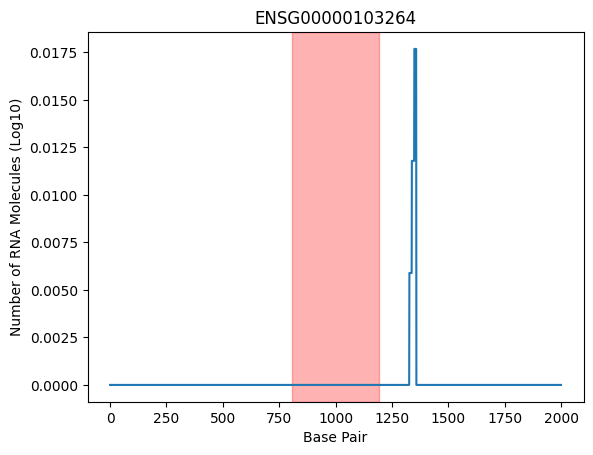

Pred: 2.4871528
Actual: 2.4873264

K562: 


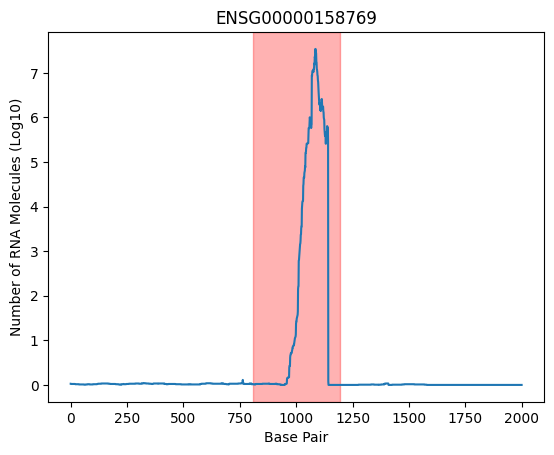

Pred: 2.9028378
Actual: 2.904061


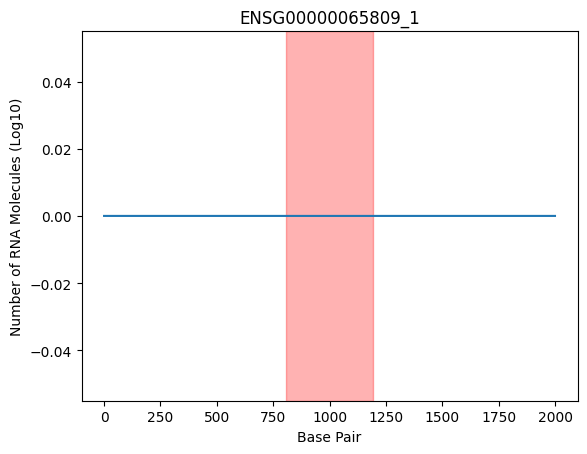

Pred: 0.65360945
Actual: 0.6531546


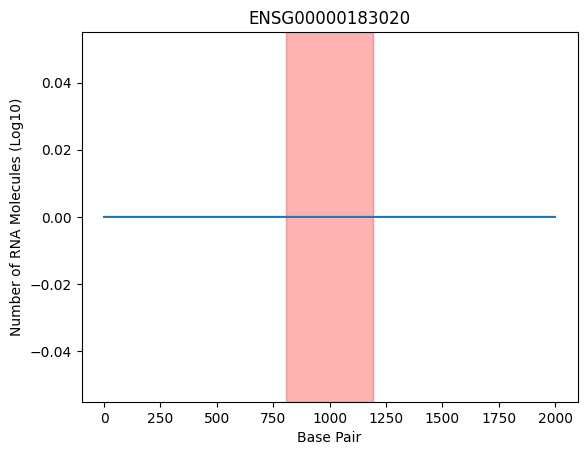

Pred: 1.9555281
Actual: 1.9558512


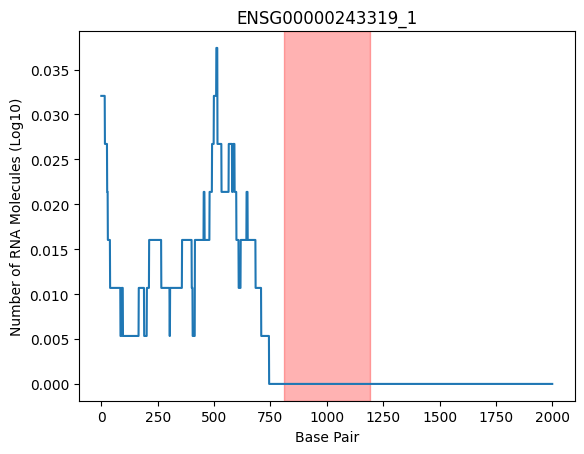

Pred: 1.2119815
Actual: 1.2118678


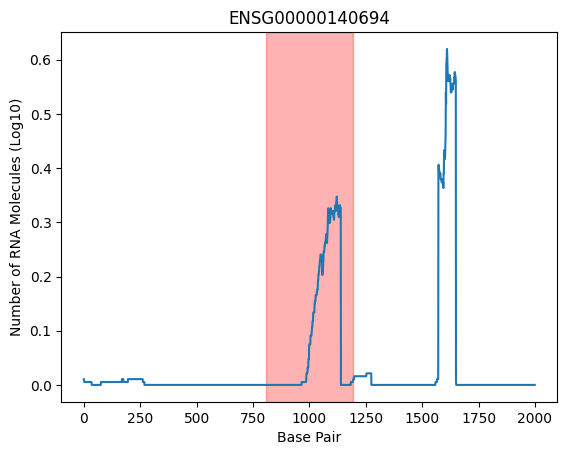

Pred: 2.7238607
Actual: 2.722443


In [244]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}") 

Best Errors (Under Expressed)

In [245]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(5, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(5, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
25048,ENSG00000040199,1.994963,1.994977,11,97.85000,0.000014,-0.000014
10316,ENSG00000100448,0.388099,0.388067,5,1.44381,0.000032,0.000032
4675,ENSG00000134318,2.148365,2.148482,2,139.76100,0.000117,-0.000117
15898,ENSG00000137497_2,1.389320,1.389067,8,23.49440,0.000253,0.000253
7661,ENSG00000266256_1,0.721748,0.721448,4,4.26560,0.000300,0.000300


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
5111,ENSG00000077380_1,2.544437,2.544399,2,344.854,0.000037,0.000037
4213,ENSG00000135638,1.893482,1.893429,2,72.215,0.000053,0.000053
12365,ENSG00000243319_1,1.211982,1.211868,6,21.033,0.000114,0.000114
15250,ENSG00000158445_1,1.699484,1.698970,7,40.263,0.000514,0.000514
13729,ENSG00000101350,1.942226,1.941427,7,297.729,0.000799,0.000799


GM12878: 


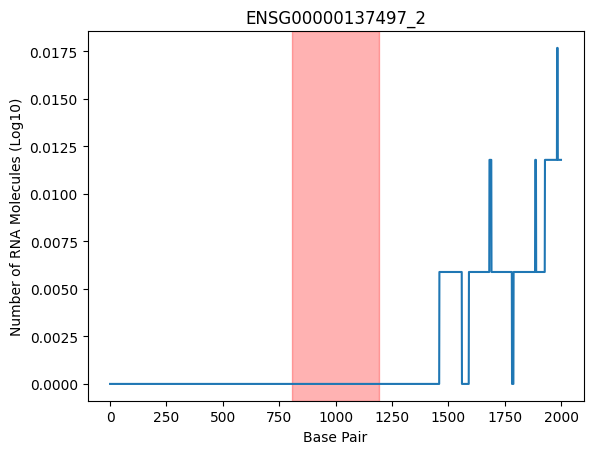

Pred: 1.3893198
Actual: 1.3890668


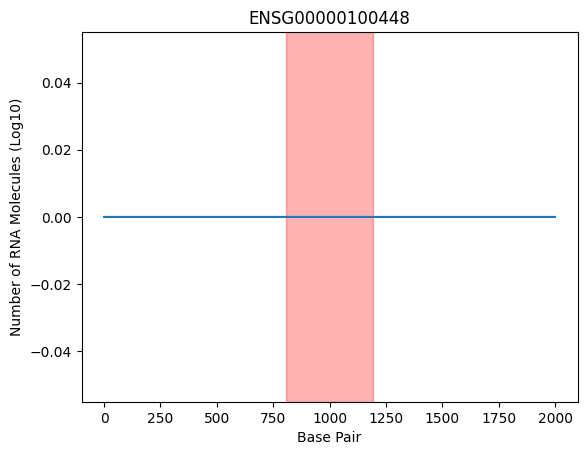

Pred: 0.3880993
Actual: 0.38806742


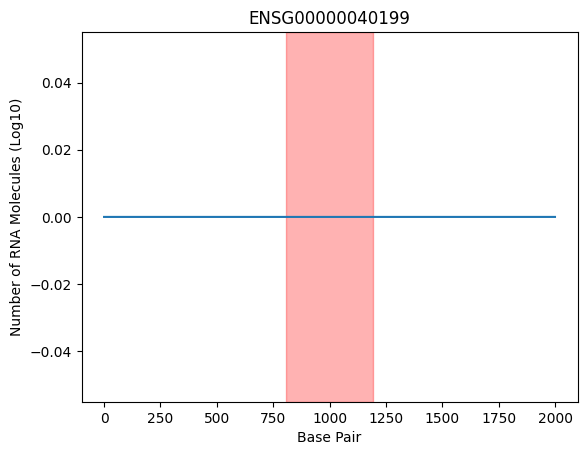

Pred: 1.9949626
Actual: 1.9949766


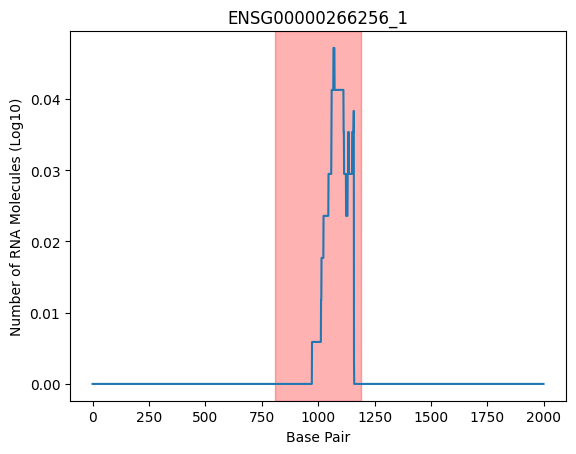

Pred: 0.7217478
Actual: 0.7214479


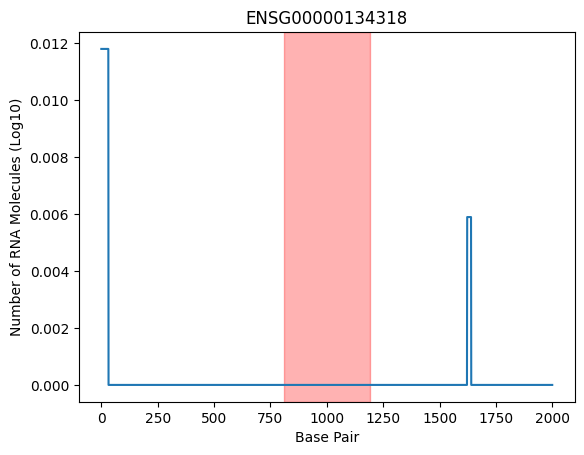

Pred: 2.148365
Actual: 2.1484823

K562: 


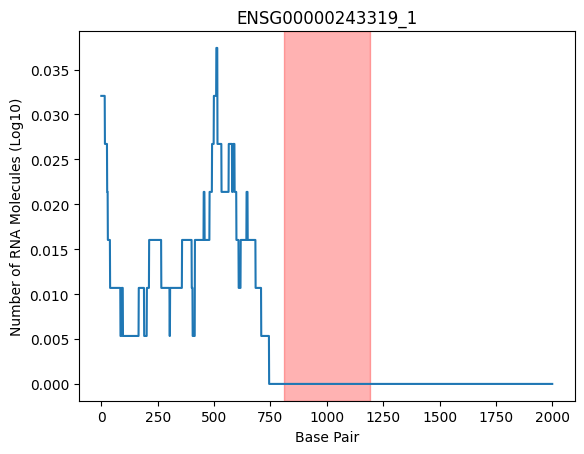

Pred: 1.2119815
Actual: 1.2118678


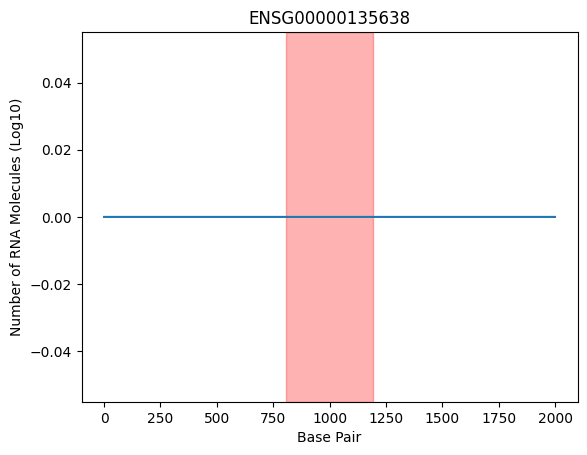

Pred: 1.8934821
Actual: 1.8934288


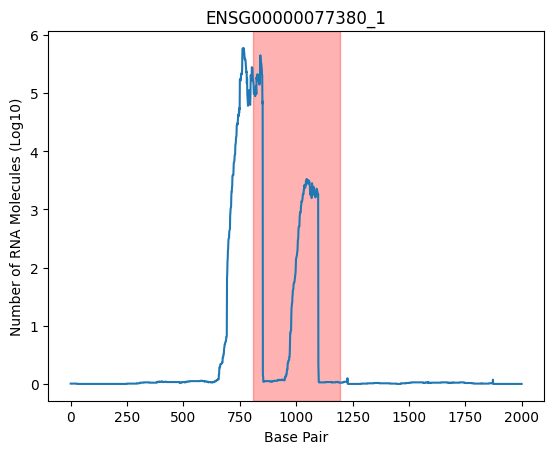

Pred: 2.5444367
Actual: 2.5443993


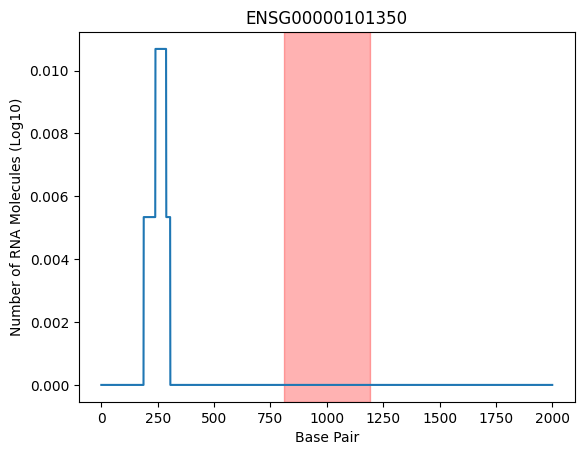

Pred: 1.942226
Actual: 1.941427


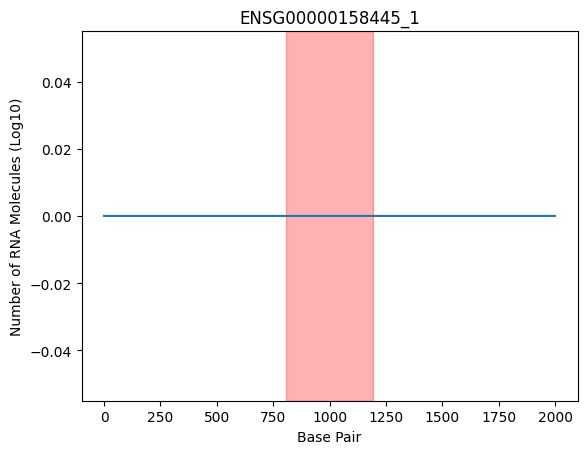

Pred: 1.6994836
Actual: 1.69897


In [246]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}") 

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4129
Percentage of TSSs with No Signal: 54.53%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000198744', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187961', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000197921', 'ENSG00000157873_1', 'ENSG00000157873_2', 'ENSG00000238164', 'ENSG00000130762', 

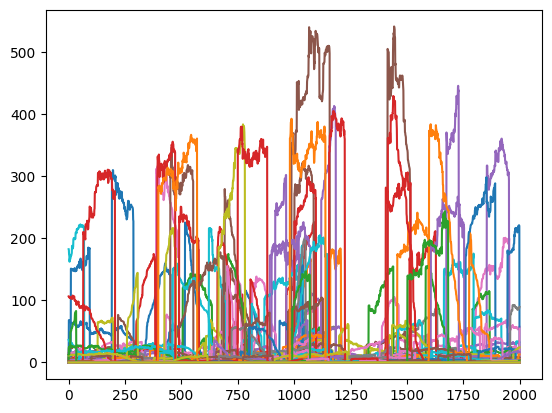

K562: 
Threshold: 0
Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 6246
Percentage of TSSs with No Signal: 48.99%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000179403', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG0000015

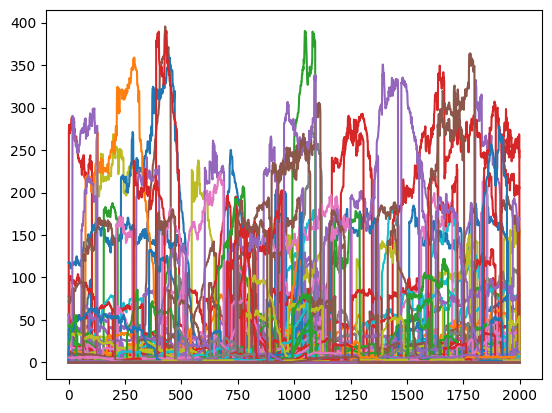

<Figure size 640x480 with 0 Axes>

In [247]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/zero", "K562")